# Alzheimer's Prediction (Multi-Class) 
* See [Alzheimer's Prediction](https://github.com/grantgasser/Alzheimers-Prediction) for a summary of this project

### Variable Descriptions
* `directory.id`	Id assigned to imaging directories. Not from LONi data
* `Subject (PTID)`	Participant ID
* `RID`	Participant roster ID
* `Image.Data.ID`	MRI ID
* `Modality`	Image type
* `Visit`	1=screening scan
* `Acq.Date`	MRI date
* `DX.bl`	Diagnosis at baseline
* `EXAMDATE`	Examination Date
* `AGE`	    Age at baseline
* `PTGENDER`	Sex
* `PTEDUCAT`	Years of Education
* `PTETHCAT`	Ethnicity
* `PTRACCAT`	Race
* `APOE4`	APOE4 genotype
* `MMSE`	MMSE score on cognitive test
* `imputed_genotype`	Challenge specific designation, TRUE=has imputed genotypes
* `APOE Genotype`	APOE allele 1 and allele 2 genotypes
* `Dx Codes for Submission`	The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

# Note: This notebook is being refactored
* More EDA
* Proper train/test split 
* Use **AUC** as main metric for evaluation as well as **Accuracy**

In [13]:
import numpy as np
import sklearn as sk
import pandas as pd
import os

In [2]:
#Read data
dat = pd.read_csv('AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

#Check NA values, 1 NA for imputed_genotype
# dat.isnull().sum()

### Remove NA

In [3]:
dat = dat.dropna()
dat.isnull().sum().sum()

0

In [4]:
#Peek at data
dat.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,9/1/2005,AD,9/12/2005,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/2005,LMCI,11/8/2005,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,9/2/2005,CN,9/7/2005,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


### Remove ID's and other features

In [5]:
X = dat
Y = dat['DX.bl']
del dat

#Remove unnecessary columns (features), remove first 9 columns and 'Dx codes for submission'
remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


## Exploratory Data Analysis (EDA)

In [6]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)
    
    print(X[var].value_counts())

Categorical variable distributions:


Distribution of imputed_genotype
True     466
False    161
Name: imputed_genotype, dtype: int64

Distribution of APOE4
0    322
1    234
2     71
Name: APOE4, dtype: int64

Distribution of PTGENDER
Male      363
Female    264
Name: PTGENDER, dtype: int64

Distribution of PTRACCAT
White    583
Black     31
Asian     13
Name: PTRACCAT, dtype: int64

Distribution of PTETHCAT
Not Hisp/Latino    616
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64

Distribution of APOE Genotype
3,3    275
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64


#### Categorical Var Distribution Notes
* Ethnicity and Race are separate vars
* Distribution of Hispanic, Black, White, Asian not quite same as overall American ethnic/racial distribution
* APOE Genotype with 3 in the first spot seems to be overwhelming majority `3,3` and `3,4`
* More males in study than females

### Numerical Variable Distributions
* All 3 distributions seem a bit right-skewed
* **Age**: `mean = 75`, `min=55`, `max=89` - seems to be no obvious bad data
* **MMSE**: `mean = 26.9`, `min=20`, `max=30` - seems to be no obvious bad data, NOTE: MMSE $\in ~(0,30)$
* **PTEDUCAT**: `mean = 15.6`, `min=6`, `max=20` - seems to be no obvious bad data. 13-14 yrs is probably high school/GED and 17-18 years is likely Bachelor's degree

Numerical Var Distributions:



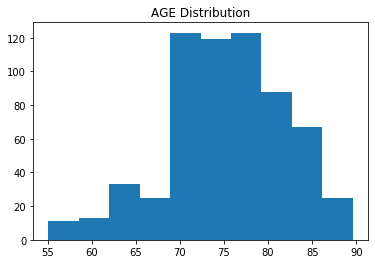

count    627.000000
mean      75.161882
std        6.689979
min       55.100000
25%       71.200000
50%       75.400000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


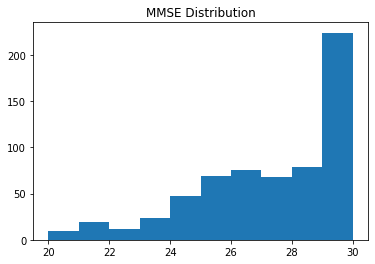

count    627.000000
mean      26.921850
std        2.563934
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


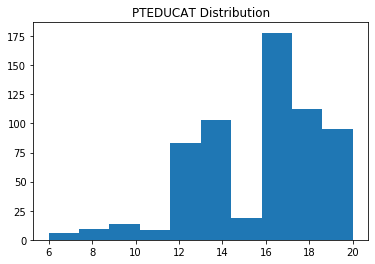

count    627.000000
mean      15.612440
std        2.978845
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Numerical Var Distributions:\n')

for var in numerical_vars:
    plt.hist(X[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X[var].describe())

### Analyze target (y) distribution
* High number (304) of limited impairment (LMCI). Maybe old age? Or the patients being evaluated are not random elderly patients but patients already known to have cognitive issues.

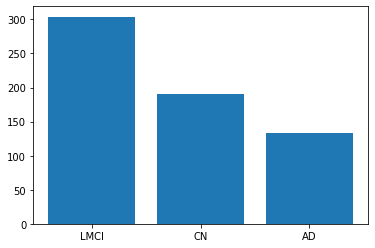

In [10]:
plt.bar(Y.value_counts().index, Y.value_counts())
plt.show()

## Pre-processing

### Convert Categorical Variables to 1-Hot
* Next time use `sklearn.preprocessing.OneHotEncoder`

In [11]:
#for each categorical var, convert to 1-hot encoding
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')
    
    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)
    
X.head(4)

Converting imputed_genotype to 1-hot encoding
Converting APOE4 to 1-hot encoding
Converting PTGENDER to 1-hot encoding
Converting PTRACCAT to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting APOE Genotype to 1-hot encoding


,AGE,PTEDUCAT,MMSE,False,True,0,1,2,Female,Male,...,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2","2,3","2,4","3,3","3,4","4,4"
0,81.3,18,20,0,1,0,1,0,0,1,...,1,0,1,0,0,0,0,0,1,0
1,67.5,10,27,1,0,1,0,0,0,1,...,1,1,0,0,0,0,0,1,0,0
2,73.7,16,29,0,1,1,0,0,0,1,...,1,0,1,0,0,0,0,1,0,0
3,80.4,13,25,0,1,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0


### Remember:
* PTGENDER: (Male, Female)
* PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
* PTRACCAT: (White, Black, Asian)
* APOE4: (0, 1, 2)
* APOE4 Genotype: (22, 23, 24, 33, 34, 44)
* imputed_genotype (True, False)

### Normalization code if necessary (for neural network)
* Could also use from `sklearn.preprocessing` `StandardScaler` or `Normalizer` or `MinMaxScaler`

In [12]:
def normalize(X):
    """
    Normalize numerical variables for faster and better convergence
    
    Args:
        X (pd.DataFrame): data
        
    Returns:
        X (numpy array): same data but with normalized numerical features
    """

    #Convert to numpy array
    X = np.array(X)
    sanity_check = 0

    #Normalize numerical variables to speed up convergence
    for i in range(3):
        mean = np.mean(X[:, i])
        sd = np.std(X[:, i])
        print('\nNormalizing', numerical_vars[i], 'with mean=', format(mean, '.2f'), 'and sd=', format(sd, '.2f'))

        X[:, i] = (X[:, i] - mean) / sd
        sanity_check += np.mean(X[:, i])

    print('\nSanity Check. Sum of all the means should be near 0:', sanity_check)

    return X

## Train/Test Split

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

print('X_train:', X_train.shape, '\ty_train:', y_train.shape)
print('X_test:', X_test.shape, '\ty_test:', y_test.shape)
num_test = X_test.shape[0]

X_train: (470, 22) 	y_train: (470,)
X_test: (157, 22) 	y_test: (157,)


## Random Forest Classifier
* A model where we can evaluate feature importance

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
rf_clf = RandomForestClassifier(n_estimators=100)
    
rf_clf.fit(X_train, y_train)
    
rf_clf_preds = rf_clf.predict(X_test)
    
rf_accuracy = (rf_clf_preds == y_test)
    
print('Test Accuracy for # estimators = {}: {}'.format(100, np.sum(rf_accuracy)/num_test))

Test Accuracy for # estimators = 100: 0.6624203821656051


### Remember:
* PTGENDER: (Male, Female)
* PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
* PTRACCAT: (White, Black, Asian)
* APOE4: (0, 1, 2)
* APOE4 Genotype: (22, 23, 24, 33, 34, 44)
* imputed_genotype (True, False)

### Feature Importance
* Unsurprisingly, performance on a cognitive test (MMSE), age (AGE), years of education (PTEDUCAT) are considered the three most important features by far
* Interestingly, the genetic information (APOE4 and APOE4 Genotype) was not considered very important by the model

In [49]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

                 Importance
MMSE               0.365526
AGE                0.290195
PTEDUCAT           0.147221
Female             0.020537
Male               0.019403
0                  0.018299
False              0.017584
True               0.016594
2,3                0.016315
3,3                0.013144
3,4                0.011443
White              0.009984
1                  0.009454
2                  0.009176
4,4                0.008600
Black              0.008101
Asian              0.005021
Not Hisp/Latino    0.004060
2,4                0.003394
Hisp/Latino        0.003058
Unknown            0.001706
2,2                0.001183


### Evaluate misclassifications, look for patterns

In [68]:
misclassified_index = (rf_clf_preds != y_test)

misclassified_index.head()

256    False
363    False
279    False
220     True
284    False
Name: DX.bl, dtype: bool

In [69]:
misclassified = X_test[misclassified_index]

misclassified.head()

,AGE,PTEDUCAT,MMSE,False,True,0,1,2,Female,Male,...,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2","2,3","2,4","3,3","3,4","4,4"
220,84.8,18,24,0,1,0,1,0,0,1,...,1,0,1,0,0,0,0,0,1,0
550,71.3,14,27,0,1,1,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
3,80.4,13,25,0,1,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
432,69.3,14,25,0,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
538,78.5,16,30,1,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,0,0


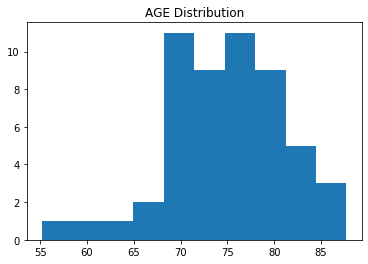

count    53.000000
mean     74.945283
std       6.413764
min      55.200000
25%      71.200000
50%      75.800000
75%      78.500000
max      87.700000
Name: AGE, dtype: float64


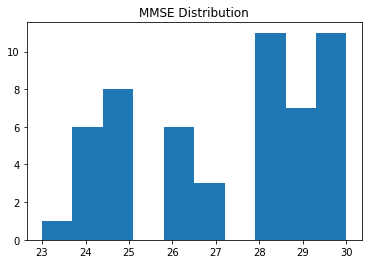

count    53.000000
mean     27.264151
std       2.158623
min      23.000000
25%      25.000000
50%      28.000000
75%      29.000000
max      30.000000
Name: MMSE, dtype: float64


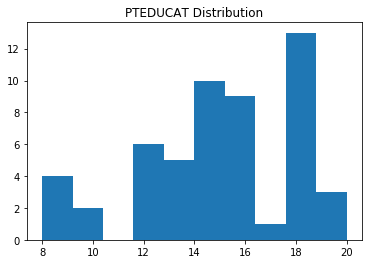

count    53.000000
mean     14.849057
std       3.090906
min       8.000000
25%      13.000000
50%      15.000000
75%      18.000000
max      20.000000
Name: PTEDUCAT, dtype: float64


In [71]:
# DRY unless you're a data scientist
for var in numerical_vars:
    plt.hist(misclassified[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(misclassified[var].describe())
    

## TODO
* Compare distributions of cat variables for misclassified examples
* Look at most common errors - e.g. is it predicted AD but actually just LMCI?
* Try a few more models and evaluate accuracy
* Then switch to binary classificiation (so map CN, LMCI => Not AD) so we have classes (Not AD, AD) and use `AUC` as metric